In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn-bright')

### Loading CSV

Load CSV and set index to datetime

In [2]:
from datetime import datetime

# Only selecting only relevant columns year (1), month (2), day (3), hour (4), pm2.5 (5), dewp (6), temp (7), pres (8), lws (10)
selected_column = ['year', 'month', 'day', 'hour', 'pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws']

data = pd.read_csv('Haze.csv', parse_dates = [['year', 'month', 'day', 'hour']],\
                   date_parser = lambda x : datetime.strptime(x, '%Y %m %d %H'),\
                   usecols = selected_column)

# Rename columns
renamed_column = ['time', 'pm2_5', 'dewPoint', 'temp', 'pressure', 'wind_speed']
data.columns = renamed_column

# Set index as time
data.set_index('time', drop = True, inplace = True)

# Drop null value (first day)
data.dropna(axis = 0, inplace = True)

# Resampling to daily basis
data = data.resample('D').interpolate('time')

In [47]:
# Differencing 1 days to remove stationarity and to take the difference in reading
DIFF = 1
ydata = data.diff(periods = DIFF).dropna()

In [48]:
ydata.tail(14)

,pm2_5,dewPoint,temp,pressure,wind_speed
time,,,,,
2014-12-18,171.0,4.0,-3.0,0.0,-316.47
2014-12-19,94.0,6.0,1.0,-6.0,-0.90
2014-12-20,-265.0,-11.0,2.0,7.0,182.83
2014-12-21,-5.0,-2.0,0.0,1.0,138.12
2014-12-22,49.0,4.0,-1.0,-9.0,-320.06
2014-12-23,89.0,4.0,-1.0,-1.0,-0.89
2014-12-24,-129.0,-3.0,7.0,3.0,0.00
2014-12-25,7.0,1.0,0.0,8.0,74.66
2014-12-26,73.0,3.0,-5.0,0.0,-71.08


In [5]:
def create_data(timeseries):
    '''
    create_data : 
    
    Args:
        timeseries (numpy array) : 
    Return:
        x (numpy array) :
        y (numpy array) :
    ''' 
    # Squeeze timeseries to 1d array and turn timeseries from numpy array to Series
    timeseries = pd.Series(np.squeeze(timeseries))
    #timeseries = pd.Series(timeseries)
    # Create lookback as the target variable, y
    y = timeseries[LOOKBACK:]
    
    # With each iteration of lag, create its column
    X = pd.DataFrame({'lag'+str(LOOKBACK-i):timeseries.shift(-i) for i in range(0, LOOKBACK)}).dropna().iloc[:-1, :]
    
    return X, y

### LSTM Conditions : 7 lookback windows and 14 days in the testing set

In [49]:
TESTDAYS = 14
LOOKBACK = 7

In [50]:
from sklearn.preprocessing import MinMaxScaler

# Scale the features to range between -1 and 1
scaler = MinMaxScaler(feature_range = (-1, 1))
scaled = scaler.fit_transform(ydata['pm2_5'].values.reshape(-1, 1))

# Create data with 7 days lookback
X, y = create_data(scaled)

# Create a train and test set (30 days)
X_train, X_test = X[ : -TESTDAYS], X[-TESTDAYS : ]
y_train, y_test = y[ : -TESTDAYS], y[-TESTDAYS : ]

# Expand X_train, X_test dimension such that it can become batch_size, timestep (added dimension here), lookback window
X_train = np.expand_dims(X_train, axis = 1)
X_test = np.expand_dims(X_test, axis = 1)

In [51]:
def transform(scaled, org_arr, scaler, test = True):
    '''
    transform: taking the scaled array, apply inverse tranform and un-differencing it
    
    Args:
        scaled (numpy array) : predicted values
        org_arr (Series) : original series
        scaler (object)

    Return:
        result (Series) : overall series
        added (Series) : only transformed series
    '''

    #scaled = scaled[:, 0]
    scaled = scaler.inverse_transform(scaled)
    
    # Remove its dimension such that it is (n, ) and turn it into a Series
    scaled = pd.Series(scaled.squeeze())
    
    if test == True:
        # Adding the differenced array with the unscaled array, this resulting series will contain values from 1 to n
        added = pd.Series(org_arr[-(DIFF + TESTDAYS) : -DIFF].values + scaled)
        
        # Adding the first value of the original array to a new Series
        result = org_arr[: -(TESTDAYS)].append(added)
    else:
        # Adding the differenced array with the unscaled array, this resulting series will contain values from 1 to n
        added = pd.Series(org_arr[LOOKBACK : -(DIFF + TESTDAYS)].values + scaled)
        
        # Adding the first value of the original array to a new Series
        result = org_arr[: (DIFF + LOOKBACK)].append(added)

    # Reset index of result
    result.reset_index(drop = True, inplace = True)
    
    return result, added

### Using a Stateless 1 Layer LSTM model

In [9]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import  TensorBoard, ModelCheckpoint

Using TensorFlow backend.


In [52]:
tensorboard = TensorBoard(log_dir = './logs')
checkpoint = ModelCheckpoint('./checkpoints/stateless_lstm.hdf5', save_best_only = True)

model = Sequential()
model.add(LSTM(4, input_shape = (None, LOOKBACK)))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

model.fit(X_train, y_train, batch_size = 1, epochs = 20, \
          callbacks = [checkpoint, tensorboard], validation_data = (X_test, y_test))

Train on 1803 samples, validate on 14 samples
Epoch 1/20
1803/1803 [==============================] - 8s - loss: 0.0437 - val_loss: 0.0760
Epoch 2/20
1803/1803 [==============================] - 7s - loss: 0.0389 - val_loss: 0.0689
Epoch 3/20
1803/1803 [==============================] - 7s - loss: 0.0370 - val_loss: 0.0672
Epoch 4/20
1803/1803 [==============================] - 7s - loss: 0.0361 - val_loss: 0.0689
Epoch 5/20
1803/1803 [==============================] - 7s - loss: 0.0358 - val_loss: 0.0687
Epoch 6/20
1803/1803 [==============================] - 7s - loss: 0.0353 - val_loss: 0.0647
Epoch 7/20
1803/1803 [==============================] - 7s - loss: 0.0351 - val_loss: 0.0681
Epoch 8/20
1803/1803 [==============================] - 7s - loss: 0.0351 - val_loss: 0.0611
Epoch 9/20
1803/1803 [==============================] - 7s - loss: 0.0349 - val_loss: 0.0629
Epoch 10/20
1803/1803 [==============================] - 7s - loss: 0.0347 - val_loss: 0.0617
Epoch 11/20
1803/1803 [

In [53]:
y_pred = model.predict(X_test)

_, predicted = transform(y_pred, data['pm2_5'], scaler)

predicted.index = data['pm2_5'][-TESTDAYS:].index

In [54]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(data['pm2_5'][-TESTDAYS:].values, predicted))
rmse

129.23990046799301

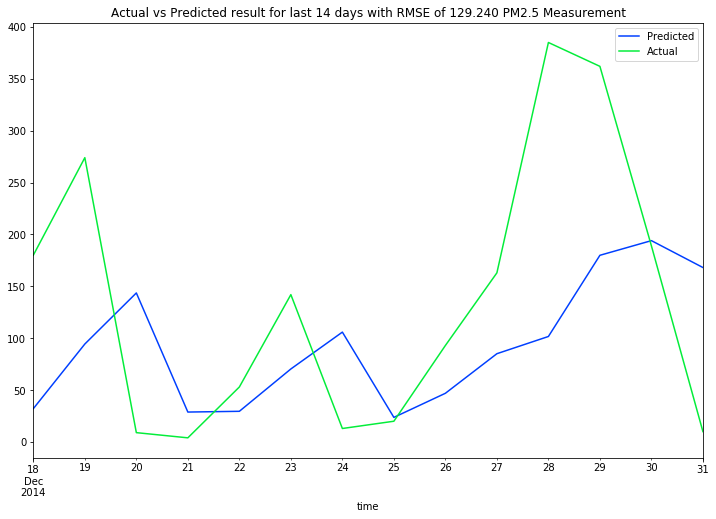

In [55]:
plt.figure(figsize = (12, 8))
plt.title('Actual vs Predicted result for last 14 days with RMSE of {:.3f} PM2.5 Measurement'.format(rmse))
predicted.plot(label = 'Predicted')
data['pm2_5'][-TESTDAYS:].plot(label = 'Actual')
plt.legend(loc = 'best')

### Stacked LSTM

In [56]:
tensorboard = TensorBoard(log_dir = './logs')
checkpoint = ModelCheckpoint('./checkpoints/stateless_2_layers_lstm.hdf5', save_best_only = True)

model = Sequential()
model.add(LSTM(32, input_shape = (None, LOOKBACK), return_sequences = True))
model.add(LSTM(32))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

model.fit(X_train, y_train, batch_size = 1, epochs = 20, \
          callbacks = [checkpoint, tensorboard], validation_data = (X_test, y_test))

Train on 1803 samples, validate on 14 samples
Epoch 1/20
1803/1803 [==============================] - 21s - loss: 0.0428 - val_loss: 0.0690
Epoch 2/20
1803/1803 [==============================] - 18s - loss: 0.0376 - val_loss: 0.0706
Epoch 3/20
1803/1803 [==============================] - 17s - loss: 0.0363 - val_loss: 0.0613
Epoch 4/20
1803/1803 [==============================] - 13s - loss: 0.0357 - val_loss: 0.0671
Epoch 5/20
1803/1803 [==============================] - 11s - loss: 0.0353 - val_loss: 0.0825
Epoch 6/20
1803/1803 [==============================] - 11s - loss: 0.0354 - val_loss: 0.0604
Epoch 7/20
1803/1803 [==============================] - 10s - loss: 0.0354 - val_loss: 0.0626
Epoch 8/20
1803/1803 [==============================] - 7s - loss: 0.0346 - val_loss: 0.0616
Epoch 9/20
1803/1803 [==============================] - 7s - loss: 0.0349 - val_loss: 0.0815
Epoch 10/20
1803/1803 [==============================] - 7s - loss: 0.0351 - val_loss: 0.0654
Epoch 11/20
1803

In [57]:
y_pred = model.predict(X_test)

_, predicted = transform(y_pred, data['pm2_5'], scaler)

predicted.index = data['pm2_5'][-TESTDAYS:].index

In [58]:
rmse = np.sqrt(mean_squared_error(data['pm2_5'][-TESTDAYS:].values, predicted))
rmse

125.40023879322925

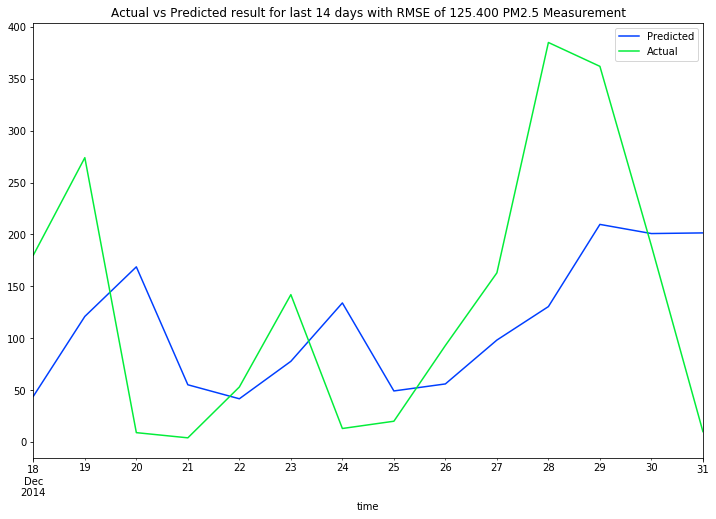

In [59]:
plt.figure(figsize = (12, 8))
plt.title('Actual vs Predicted result for last 14 days with RMSE of {:.3f} PM2.5 Measurement'.format(rmse))
predicted.plot(label = 'Predicted')
data['pm2_5'][-TESTDAYS:].plot(label = 'Actual')
plt.legend(loc = 'best')